In [1]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()
transforms = [pose.pose_flip_lr(p=0.5)], None
data = (pose.PoseItemList.from_folder(root)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose.LIPLabel(root /'pose_annotations'))
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (30462 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [3]:
class SampleOneInstuctor(cs.BaseInstructor):
    def __init__(self, n_inst):
        self.n_inst = n_inst
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train:
            batch_size = last_input.shape[0]
            instructions = torch.arange(self.n_inst, device=last_input.device).expand(batch_size, -1).T
            return {'last_input': (last_input, instructions)}
        
        is_valid = (last_target[..., 2] > 0)

        # filter datapoints with no visible points
        has_keypoints = is_valid.any(dim=1)
        gt = last_target[..., :2][has_keypoints]
        is_valid = is_valid[has_keypoints]
        last_input = last_input[has_keypoints]

        # choose a random valid keypoint
        instructions = torch.multinomial(is_valid.float() , 1).reshape(1, -1)
        assert not torch.isnan(gt)[range(len(gt)), instructions[0]].any()

        # hide keypoints that were not selected 
        visible = torch.zeros_like(is_valid).float()
        visible[range(len(visible)), instructions[0]] = 1
        target = torch.cat((gt, visible[..., None]), dim=-1)

        return {'last_input': (last_input, instructions), 'last_target': target}
            
    def on_loss_begin(self, last_input, last_output, last_target, train, **kwargs: Any):
        if train:
            bu, td = last_output
            td = td.squeeze(dim=1)
            return {'last_output': (bu, td)}


def loss(outputs, targets):
    bu, td = outputs
    is_visible = targets[..., 2] > 0
    gt = targets[is_visible][..., :2]
    if td.ndim == 4:
        # validation mode
        td = td[is_visible]
    return pose.ce_loss(td, gt)

In [4]:
instructor = SampleOneInstuctor(16)
c_out = 1
learner = cs.cs_learner(data, models.resnet18, c_out, instructor, td_laterals=False,
                        loss_func=loss, callback_fns=pose.Pckh)

In [5]:
learner.lr_find()

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 1.58E-01


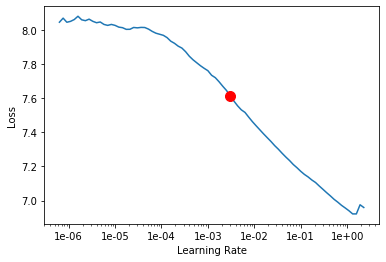

In [7]:
learner.recorder.plot(suggestion=True)

In [8]:
lr = 1e-2
learner.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.933054,5.683921,0.353441,0.134181,0.055302,0.083373,0.042734,0.050409,0.070086,0.159441,0.118614,07:51
1,4.999307,4.805198,0.727488,0.467193,0.218114,0.218943,0.124610,0.106694,0.132804,0.414042,0.301791,05:12
2,4.627661,4.410727,0.761591,0.547102,0.352419,0.272463,0.243758,0.320578,0.374511,0.489142,0.418749,06:43
3,4.378005,3.997681,0.774881,0.617997,0.424985,0.339948,0.361664,0.383401,0.448310,0.544715,0.486560,07:18
4,4.229961,3.889217,0.787657,0.637582,0.450653,0.364118,0.397750,0.415586,0.459101,0.565123,0.509790,06:42


In [10]:
learner.unfreeze()

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 1.91E-05


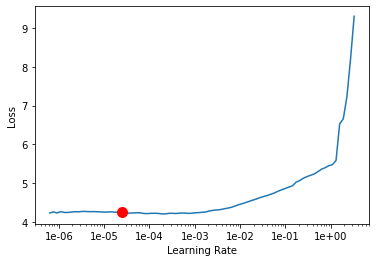

In [11]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [12]:
learner.fit_one_cycle(20, slice(2.5e-5, lr/5))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.239972,3.899360,0.790490,0.638372,0.448152,0.366686,0.397121,0.413966,0.461818,0.566084,0.510367,05:54
1,4.173904,3.826224,0.792757,0.657539,0.469914,0.393135,0.414252,0.440644,0.480812,0.583233,0.528916,07:35
2,4.097151,3.830130,0.787657,0.670233,0.473699,0.405077,0.422648,0.443864,0.485536,0.588963,0.534618,05:18
3,4.081441,3.771038,0.796157,0.679310,0.504659,0.421507,0.427415,0.454238,0.485961,0.605003,0.546592,01:31
4,4.065948,3.768896,0.811148,0.671438,0.502822,0.433527,0.447608,0.430195,0.501637,0.609317,0.550943,01:16
5,3.981091,3.696305,0.824593,0.704962,0.532998,0.443427,0.447834,0.486209,0.525464,0.631167,0.574033,01:18
6,3.911474,3.652302,0.821554,0.701148,0.532165,0.452425,0.466040,0.485442,0.517550,0.631394,0.575986,01:17
7,3.868656,3.570207,0.832784,0.719931,0.569565,0.472833,0.491794,0.502480,0.525935,0.653124,0.596307,01:15
8,3.831346,3.539641,0.835154,0.725364,0.575195,0.494267,0.500599,0.502341,0.539364,0.661658,0.604325,01:16
9,3.758552,3.530895,0.832217,0.726087,0.588466,0.506010,0.506997,0.527756,0.548645,0.667161,0.612862,01:27


In [13]:
data = (pose.PoseItemList.from_folder(root)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose.LIPLabel(root /'pose_annotations'))
        .transform(transforms, tfm_y=True, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=32)
        .normalize(imagenet_stats))
learner.data = data

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.31E-08


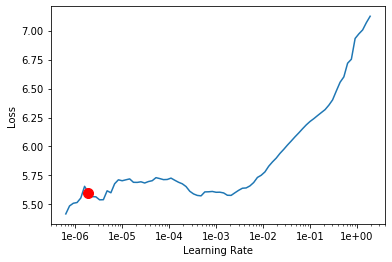

In [14]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
learner.fit_one_cycle(20, slice(2e-6, 1e-3))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.936563,4.401477,0.868793,0.766451,0.624690,0.567512,0.485081,0.459831,0.493297,0.710594,0.621926,04:38
1,4.802348,4.299890,0.875386,0.781957,0.652732,0.592976,0.522573,0.513678,0.520137,0.729225,0.648700,02:27
2,4.763471,4.250262,0.879868,0.788796,0.661670,0.594757,0.545640,0.536172,0.536675,0.734781,0.660195,02:22
3,4.666567,4.218827,0.881620,0.781174,0.670291,0.603657,0.558368,0.555435,0.552829,0.737519,0.667949,03:28
4,4.606269,4.194043,0.876674,0.789481,0.673340,0.620244,0.560289,0.564938,0.568910,0.743088,0.674575,05:45
5,4.566567,4.178816,0.886101,0.787858,0.674123,0.623148,0.563008,0.573677,0.579814,0.746013,0.679049,07:02
6,4.514666,4.149502,0.885380,0.791983,0.676156,0.620852,0.581276,0.578628,0.577384,0.746855,0.682692,05:51
7,4.484235,4.148029,0.885638,0.789688,0.678266,0.629805,0.577884,0.581110,0.576630,0.749005,0.683730,05:39
8,4.381156,4.121225,0.884350,0.801331,0.686811,0.632853,0.591751,0.590856,0.592041,0.754441,0.692045,06:50
9,4.463279,4.093734,0.891562,0.800235,0.692766,0.637149,0.588555,0.607202,0.603777,0.758528,0.697384,06:39


In [16]:
learner.fit_one_cycle(10, slice(2e-6, 1e-3))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.198952,4.001943,0.894756,0.816107,0.713738,0.666767,0.616348,0.630527,0.631147,0.775650,0.717994,05:01
1,4.289488,4.051372,0.894292,0.812453,0.707614,0.655349,0.602630,0.619048,0.623331,0.770348,0.710380,04:24
2,4.276582,4.056305,0.889913,0.806605,0.704686,0.653221,0.600930,0.611051,0.615542,0.766488,0.705905,04:44
3,4.215716,4.068195,0.890068,0.809680,0.704860,0.658740,0.599803,0.624898,0.619096,0.768691,0.709210,04:06
4,4.181818,4.055491,0.892232,0.810987,0.706705,0.657487,0.604954,0.625868,0.620242,0.769733,0.710882,04:36
5,4.179179,4.021390,0.894241,0.815586,0.709225,0.671237,0.608566,0.629014,0.631341,0.775356,0.716469,04:17
6,4.119823,4.003270,0.893159,0.817307,0.720401,0.674686,0.618309,0.639981,0.634802,0.779069,0.721974,04:46
7,4.116563,3.989950,0.893623,0.816157,0.724070,0.680128,0.620931,0.641809,0.639199,0.781112,0.724331,04:55
8,4.018891,3.990885,0.895374,0.820854,0.725561,0.681487,0.623829,0.640438,0.637809,0.783450,0.725888,04:26
9,4.076046,3.980839,0.896404,0.820226,0.724932,0.682539,0.620278,0.641684,0.639821,0.783663,0.725855,06:31


In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(5, slice(7e-7, 5e-4))

In [ ]:
learner.fit_one_cycle(15, slice(7e-7, 5e-4))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.92E-07


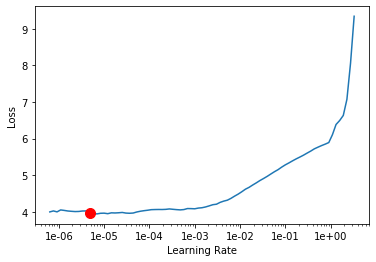

In [18]:
learner.fit_one_cycle(5, slice(7e-7, 5e-4))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.059347,3.992168,0.894447,0.819970,0.718922,0.680053,0.620551,0.641761,0.640139,0.781005,0.724298,25:42
1,4.057141,4.014914,0.893416,0.819967,0.719779,0.679481,0.613396,0.638583,0.635866,0.780818,0.722254,10:30
2,3.960097,4.001077,0.896250,0.821477,0.722822,0.679690,0.626009,0.643778,0.636499,0.782728,0.726053,22:42
3,4.034881,3.979048,0.897383,0.823887,0.723608,0.683777,0.621696,0.646463,0.641435,0.784812,0.727553,08:07
4,3.997860,3.978365,0.896919,0.824668,0.723336,0.685661,0.624050,0.643644,0.643225,0.785279,0.728031,05:30


In [19]:
learner.fit_one_cycle(15, slice(7e-7, 5e-4))

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.978818,3.974791,0.897022,0.823780,0.723451,0.683314,0.622570,0.644689,0.645691,0.784545,0.727751,06:01
1,3.994171,3.976306,0.895322,0.824511,0.724459,0.684914,0.624534,0.648492,0.645389,0.784932,0.728731,07:34
2,4.048513,3.991271,0.894498,0.817304,0.726205,0.684729,0.620774,0.640613,0.645521,0.783249,0.726152,10:07
3,4.033835,3.998244,0.895992,0.820019,0.722491,0.680677,0.620215,0.648316,0.644158,0.782461,0.726399,10:29
4,3.988717,4.020319,0.899135,0.819237,0.720458,0.677742,0.619607,0.642970,0.641202,0.781847,0.724949,07:01
5,4.022809,4.001295,0.896971,0.818349,0.719829,0.682566,0.616651,0.647585,0.641659,0.782061,0.725262,06:37
6,3.976334,4.003572,0.895992,0.820860,0.725512,0.683276,0.619000,0.648371,0.642532,0.784010,0.727009,06:07
7,4.012358,3.992059,0.897692,0.816886,0.723886,0.683546,0.620535,0.646396,0.641923,0.783116,0.726375,06:17
8,3.909996,4.010989,0.900371,0.821538,0.725726,0.688608,0.623216,0.652894,0.647796,0.786668,0.730412,07:28
9,3.910990,3.990654,0.901041,0.821953,0.731102,0.690116,0.623868,0.653725,0.647021,0.788605,0.731731,05:02
